In [1]:
from __future__ import absolute_import
from __future__ import print_function
from __future__ import division

import datetime
import os
import sys
import getopt
import errno

sys.path.insert(0,"/home/sunnycui/deepcell-tf")

In [2]:
import math
import numpy as np
from tensorflow.python.keras import backend as K
from tensorflow.python.keras import callbacks
from tensorflow.python.keras.optimizers import SGD

from tensorflow.python.keras.utils.data_utils import get_file

import deepcell
from deepcell import losses
from scripts.recurr_gru import image_gen
from deepcell import image_generators
from deepcell import model_zoo
from deepcell.layers import TensorProduct, ReflectionPadding3D, DilatedMaxPool3D

from deepcell.utils import train_utils
from deepcell.utils.data_utils import get_data
from deepcell.utils.train_utils import rate_scheduler
from deepcell.training import train_model_conv


from tensorflow.python.keras.layers import MaxPool3D, Conv3DTranspose, UpSampling3D
from scripts.recurr_gru.conv_gru_layer import ConvGRU2D
from tensorflow.python.keras.layers import BatchNormalization, Dropout, LeakyReLU
from tensorflow.python.keras.layers import Conv3D, ZeroPadding3D, ConvLSTM2D, Cropping3D
from tensorflow.python.keras.layers import Input, Add, Concatenate, Flatten
from tensorflow.python.keras.engine.input_layer import InputLayer

from tensorflow.python.keras.models import Model


from tensorflow.python.keras.regularizers import l2
from deepcell.layers import ImageNormalization3D
from tensorflow.python.keras.models import Sequential
from tensorflow.python.keras.layers import Activation, Softmax

from sklearn.model_selection import train_test_split

from tensorflow.python.client import device_lib

Instructions for updating:
Colocations handled automatically by placer.


In [3]:
MODEL_DIR = os.path.join(sys.path[0], 'scripts/recurr_gru/models/')
LOG_DIR = os.path.join(sys.path[0], 'scripts/recurr_gru/logs/')
DATA_DIR = os.path.join(sys.path[0], 'scripts/recurr_gru/data/')

# Download  Datasets

### Download three different sets of data

### Compile multiple TRK files into one

### Combine multiple npz files

In [9]:
from deepcell.utils.tracking_utils import load_trks

# Load data
# From data_utils.py

filename = 'combined_data.npz'
DATA_FILE = os.path.join(DATA_DIR, filename)


print("Loading data from " + filename)
train_dict, test_dict = get_data(DATA_FILE, mode='conv', test_size=0.2, seed=0)

print(' -\nX.shape: {}\ny.shape: {}'.format(train_dict['X'].shape, train_dict['y'].shape))

'''

training_data = get_data(DATA_FILE)
X = training_data['X']
y = training_data['y']

        
X_train, X_test, y_train, y_test = train_test_split(
            X, y, test_size=0.2, random_state=0)


train_dict = {
    'X': X_train,
    'y': y_train,
}

test_dict = {
    'X': X_test,
    'y': y_test,
}'''

Loading data from combined_data.npz
 -
X.shape: (543, 30, 135, 160, 1)
y.shape: (543, 30, 135, 160, 1)


"\n\ntraining_data = get_data(DATA_FILE)\nX = training_data['X']\ny = training_data['y']\n\n        \nX_train, X_test, y_train, y_test = train_test_split(\n            X, y, test_size=0.2, random_state=0)\n\n\ntrain_dict = {\n    'X': X_train,\n    'y': y_train,\n}\n\ntest_dict = {\n    'X': X_test,\n    'y': y_test,\n}"

In [5]:
print(np.unique(test_dict['y'][2]))

[ 0.  1.  2.  3.  4.  5.  6.  7.  8.  9. 10. 11. 12. 13. 14. 15. 16. 17.
 19. 21.]


# Models

In [24]:
def feature_net_3D(receptive_field=61,
                    n_frames=3,
                    input_shape=(5, 256, 256, 1),
                    n_features=3,
                    n_channels=1,
                    reg=1e-5,
                    n_conv_filters=64,
                    n_dense_filters=200,
                    gru_kernel_size =3,
                    VGG_mode=False,
                    init='he_normal',
                    norm_method='whole_image',
                    gru=False,
                    location=False,
                    dilated=False,
                    padding=False,
                    padding_mode='reflect',
                    multires=False,
                    include_top=True):
    # Create layers list (x) to store all of the layers.
    # We need to use the functional API to enable the multiresolution mode
    x = []

    win = (receptive_field - 1) // 2
    win_z = (n_frames - 1) // 2

    if dilated:
        padding = True

    if K.image_data_format() == 'channels_first':
        channel_axis = 1
        time_axis = 2
        row_axis = 3
        col_axis = 4
        if not dilated:
            input_shape = (n_channels, n_frames, receptive_field, receptive_field)
    else:
        channel_axis = -1
        time_axis = 1
        row_axis = 2
        col_axis = 3
        if not dilated:
            input_shape = (n_frames, receptive_field, receptive_field, n_channels)

    x.append(Input(shape=input_shape))
    # x.append(ImageNormalization3D(norm_method=norm_method, filter_size=receptive_field)(x[-1]))
    # x.append(BatchNormalization(axis=channel_axis)(x[-1]))

    if padding:
        if padding_mode == 'reflect':
            x.append(ReflectionPadding3D(padding=(win_z, win, win))(x[-1]))
        elif padding_mode == 'zero':
            x.append(ZeroPadding3D(padding=(win_z, win, win))([-1]))

    if location:
        x.append(Location3D(in_shape=tuple(x[-1].shape.as_list()[1:]))(x[-1]))
        x.append(Concatenate(axis=channel_axis)([x[-2], x[-1]]))

    if multires:
        layers_to_concat = []

    rf_counter = receptive_field
    block_counter = 0
    d = 1

    append_gru = False
    while rf_counter > 4:
        filter_size = 3 if rf_counter % 2 == 0 else 4
        if append_gru == True:
            x.append(ConvGRU2D(filters=n_conv_filters, kernel_size=(filter_size, filter_size), dilation_rate=(d, d),
                            padding='valid', kernel_initializer=init,
                            kernel_regularizer=l2(reg), return_sequences=True)(x[-1]))
        else:
            x.append(Conv3D(n_conv_filters, (1, filter_size, filter_size), 
                            dilation_rate=(1, d, d), kernel_initializer=init,
                            padding='valid', kernel_regularizer=l2(reg))(x[-1]))

        
        x.append(BatchNormalization(axis=channel_axis)(x[-1]))
        x.append(Activation('relu')(x[-1]))

        block_counter += 1
        rf_counter -= filter_size - 1

        if block_counter % 2 == 0:
            if dilated:
                x.append(DilatedMaxPool3D(dilation_rate=(1, d, d), pool_size=(1, 2, 2))(x[-1]))
                d *= 2
            else:
                x.append(MaxPool3D(pool_size=(1, 2, 2))(x[-1]))

            if VGG_mode:
                n_conv_filters *= 2

            rf_counter = rf_counter // 2

            if multires:
                layers_to_concat.append(len(x) - 1)

    if multires:
        c = []
        for l in layers_to_concat:
            output_shape = x[l].get_shape().as_list()
            target_shape = x[-1].get_shape().as_list()
            time_crop = (0, 0)

            row_crop = int(output_shape[row_axis] - target_shape[row_axis])

            if row_crop % 2 == 0:
                row_crop = (row_crop // 2, row_crop // 2)
            else:
                row_crop = (row_crop // 2, row_crop // 2 + 1)

            col_crop = int(output_shape[col_axis] - target_shape[col_axis])

            if col_crop % 2 == 0:
                col_crop = (col_crop // 2, col_crop // 2)
            else:
                col_crop = (col_crop // 2, col_crop // 2 + 1)

            cropping = (time_crop, row_crop, col_crop)

            c.append(Cropping3D(cropping=cropping)(x[l]))
        x.append(Concatenate(axis=channel_axis)(c))
        
    
    x.append(Conv3D(n_dense_filters, (1, rf_counter, rf_counter), dilation_rate=(1, d, d), kernel_initializer=init, padding='valid', kernel_regularizer=l2(reg))(x[-1]))
    x.append(BatchNormalization(axis=channel_axis)(x[-1]))
    x.append(Activation('relu')(x[-1]))

    x.append(Conv3D(n_dense_filters, (n_frames, 1, 1), dilation_rate=(1, d, d), kernel_initializer=init, padding='valid', kernel_regularizer=l2(reg))(x[-1]))
    x.append(BatchNormalization(axis=channel_axis)(x[-1]))
    x.append(Activation('relu')(x[-1]))
    
    if gru == True:
        x.append(ConvGRU2D(filters=n_conv_filters, kernel_size=(gru_kernel_size, gru_kernel_size),
                            padding='same', kernel_initializer=init, activation='relu',
                            kernel_regularizer=l2(reg), return_sequences=True)(x[-1]))
        x.append(BatchNormalization(axis=channel_axis)(x[-1]))
        # x.append(Activation('relu')(x[-1]))
        x.append(ConvGRU2D(filters=n_conv_filters, kernel_size=(gru_kernel_size +2, gru_kernel_size +2),
                            padding='same', kernel_initializer=init, activation='relu',
                            kernel_regularizer=l2(reg), return_sequences=True)(x[-1]))
        x.append(BatchNormalization(axis=channel_axis)(x[-1]))
        # x.append(Activation('relu')(x[-1]))
    
    
    x.append(TensorProduct(n_dense_filters, kernel_initializer=init, kernel_regularizer=l2(reg))(x[-1]))
    x.append(BatchNormalization(axis=channel_axis)(x[-1]))
    x.append(Activation('relu')(x[-1]))

    x.append(TensorProduct(n_features, kernel_initializer=init, kernel_regularizer=l2(reg))(x[-1]))

    if not dilated:
        x.append(Flatten()(x[-1]))

    if include_top:
        x.append(Softmax(axis=channel_axis)(x[-1]))

    model = Model(inputs=x[0], outputs=x[-1])
    model.summary()

    return model

In [25]:
from tensorflow.python.keras.layers import Lambda;

def image_norm(inputs):
    if K.image_data_format() == 'channels_first':
        channel_axis = 1
    else:
        channel_axis = -1
    axes = [3, 4] if channel_axis == 1 else [2, 3]
    output = inputs - K.mean(inputs, axis=axes, keepdims=True)
    output = output / K.std(inputs, axis=axes, keepdims=True)
    return output

def feature_net_skip_3D(receptive_field=61,
                        input_shape=(5, 256, 256, 1),
                        fgbg_model=None,
                        gru=False,
                        gru_kernel_size=3,
                        last_only=True,
                        n_skips=1,
                        norm_method='whole_image',
                        padding_mode='reflect',
                        **kwargs):
    # print(K.image_data_format())
    if K.image_data_format() == 'channels_first':
        channel_axis = 1
    else:
        channel_axis = -1

    inputs = Input(shape=input_shape)
    
    img = Lambda(image_norm)(inputs)
    #img = BatchNormalization(axis=channel_axis)(inputs)

    models = []
    model_outputs = []

    if fgbg_model is not None:
        for layer in fgbg_model.layers:
            layer.trainable = False
        models.append(fgbg_model)
        fgbg_output = fgbg_model(inputs)
        if isinstance(fgbg_output, list):
            fgbg_output = fgbg_output[-1]
        model_outputs.append(fgbg_output)

    for _ in range(n_skips + 1):
        if model_outputs:
            model_input = Concatenate(axis=channel_axis)([img, model_outputs[-1]])
        else:
            model_input = img
        new_input_shape = model_input.get_shape().as_list()[1:]
        models.append(feature_net_3D(receptive_field=receptive_field, 
                                     input_shape=new_input_shape, norm_method=None, dilated=True, 
                                     padding=True, padding_mode=padding_mode, gru=gru, 
                                     gru_kernel_size=gru_kernel_size, **kwargs))
        model_outputs.append(models[-1](model_input))

    if last_only:
        model = Model(inputs=inputs, outputs=model_outputs[-1])
    else:
        if fgbg_model is None:
            model = Model(inputs=inputs, outputs=model_outputs)
        else:
            model = Model(inputs=inputs, outputs=model_outputs[1:])
    model.summary()
    return model

# Test Edge Segmentation

In [26]:
from deepcell.utils.transform_utils import deepcell_flat_transform

def test_edge_seg():
    X, y = train_dict['X'][:4], train_dict['y'][:4]
    data_format = 'channels_last'
    dilation_radius = 1
    y_transform = deepcell_flat_transform(y, dilation_radius, data_format=data_format)
    return y_transform

    
y_transform = test_edge_seg()

Text(0.5, 1.0, 'background, frame = 10')

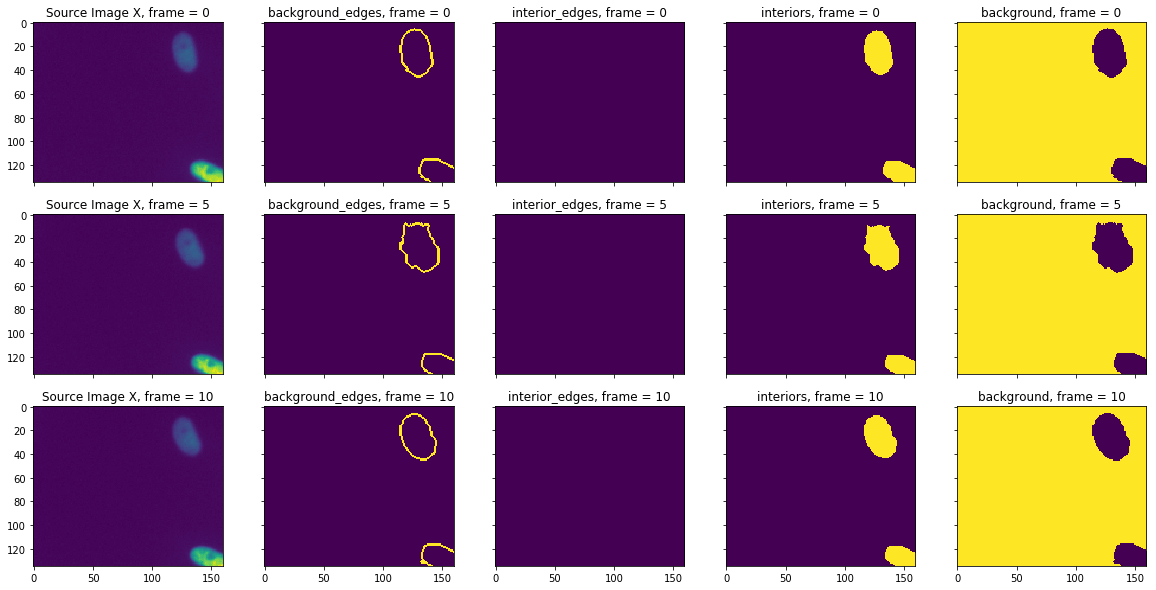

In [18]:
import matplotlib.pyplot as plt 

X_temp = train_dict['X'][:1]
y_temp = train_dict['y'][:1]

fig, axes = plt.subplots(ncols=5, nrows=3, figsize=(20, 10), sharex=True, sharey=True)
ax = axes.ravel()

ax[0].imshow(X_temp[0, 0, ..., 0])
ax[0].set_title('Source Image X, frame = 0')

ax[1].imshow(y_transform[0, 0, ..., 1])
ax[1].set_title('background_edges, frame = 0')

ax[2].imshow(y_transform[0, 0, ..., 0])
ax[2].set_title('interior_edges, frame = 0')

ax[3].imshow(y_transform[0, 0, ..., 2])
ax[3].set_title('interiors, frame = 0')

ax[4].imshow(y_transform[0, 0, ..., 3])
ax[4].set_title('background, frame = 0')

ax[5].imshow(X_temp[0, 5, ..., 0])
ax[5].set_title('Source Image X, frame = 5')

ax[6].imshow(y_transform[0, 5, ..., 1])
ax[6].set_title('background_edges, frame = 5')

ax[7].imshow(y_transform[0, 5, ..., 0])
ax[7].set_title('interior_edges, frame = 5')

ax[8].imshow(y_transform[0, 5, ..., 2])
ax[8].set_title('interiors, frame = 5')

ax[9].imshow(y_transform[0, 5, ..., 3])
ax[9].set_title('background, frame = 5')

ax[10].imshow(X_temp[0, 10, ..., 0])
ax[10].set_title('Source Image X, frame = 10')

ax[11].imshow(y_transform[0, 10, ..., 1])
ax[11].set_title('background_edges, frame = 10')

ax[12].imshow(y_transform[0, 10, ..., 0])
ax[12].set_title('interior_edges, frame = 10')

ax[13].imshow(y_transform[0, 10, ..., 2])
ax[13].set_title('interiors, frame = 10')

ax[14].imshow(y_transform[0, 10, ..., 3])
ax[14].set_title('background, frame = 10')

Text(0.5, 1.0, 'interiors, frame = 10')

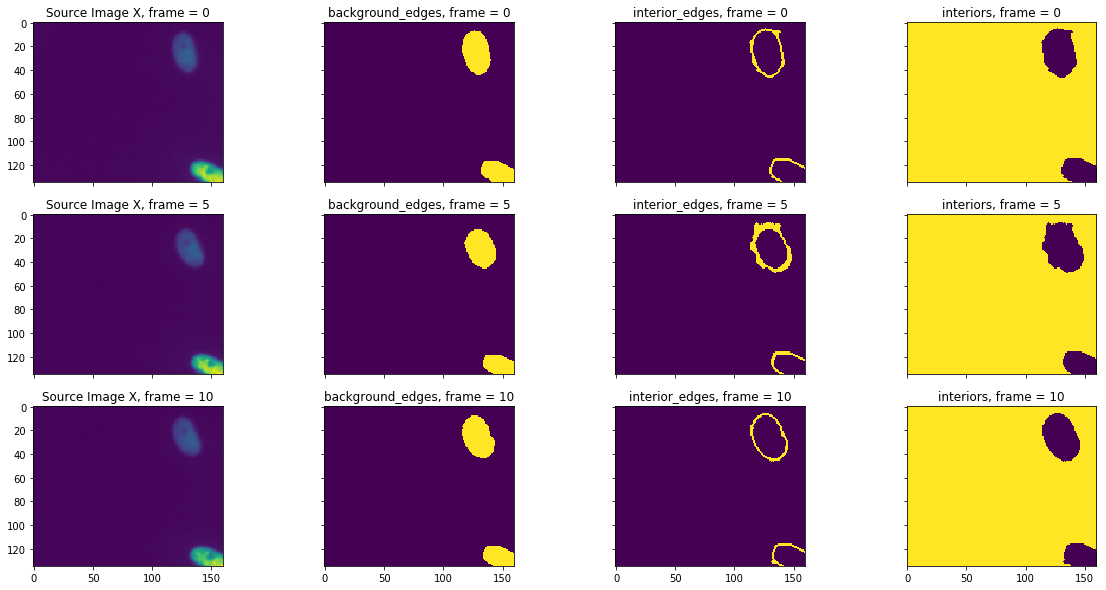

In [12]:
from deepcell.utils.transform_utils import pixelwise_transform

def test_edge_seg():
    X, y = train_dict['X'][:1], train_dict['y'][:1]
    data_format = 'channels_last'
    dilation_radius = 1
    y_transform = pixelwise_transform(y, dilation_radius, data_format=data_format)
    return y_transform
    
y_transform = test_edge_seg()
import matplotlib.pyplot as plt 

X_temp = train_dict['X'][:4]
y_temp = train_dict['y'][:4]

fig, axes = plt.subplots(ncols=4, nrows=3, figsize=(20, 10), sharex=True, sharey=True)

ax = axes.ravel()

ax[0].imshow(X_temp[0, 0, ..., 0])
ax[0].set_title('Source Image X, frame = 0')

ax[1].imshow(y_transform[0, 0, ..., 1])
ax[1].set_title('background_edges, frame = 0')

ax[2].imshow(y_transform[0, 0, ..., 0])
ax[2].set_title('interior_edges, frame = 0')

ax[3].imshow(y_transform[0, 0, ..., 2])
ax[3].set_title('interiors, frame = 0')

ax[4].imshow(X_temp[0, 5, ..., 0])
ax[4].set_title('Source Image X, frame = 5')

ax[5].imshow(y_transform[0, 5, ..., 1])
ax[5].set_title('background_edges, frame = 5')

ax[6].imshow(y_transform[0, 5, ..., 0])
ax[6].set_title('interior_edges, frame = 5')

ax[7].imshow(y_transform[0, 5, ..., 2])
ax[7].set_title('interiors, frame = 5')

ax[8].imshow(X_temp[0, 10, ..., 0])
ax[8].set_title('Source Image X, frame = 10')

ax[9].imshow(y_transform[0, 10, ..., 1])
ax[9].set_title('background_edges, frame = 10')

ax[10].imshow(y_transform[0, 10, ..., 0])
ax[10].set_title('interior_edges, frame = 10')

ax[11].imshow(y_transform[0, 10, ..., 2])
ax[11].set_title('interiors, frame = 10')

# Create and train foreground/background separation model

In [20]:
def create_and_train_fgbg(lr_sched, train_dict, test_dict, fgbg_gru_model_name, gru_kernel_size=3, gru=False):
    
    fgbg_model = feature_net_skip_3D(
        receptive_field=receptive_field,
        n_features=2,  # segmentation mask (is_cell, is_not_cell)
        n_frames=frames_per_batch,
        n_skips=n_skips,
        n_conv_filters=32,
        n_dense_filters=128,
        gru=gru,
        gru_kernel_size=gru_kernel_size,
        input_shape=tuple([frames_per_batch] + list(train_dict['X'].shape[2:])),
        multires=False,
        last_only=False,
        norm_method=norm_method)

    print("Training fgbg model. \n")

    fgbg_model = train_model_conv(
        model=fgbg_model,
        train_dict=train_dict,
        test_dict=test_dict,
        model_name=fgbg_gru_model_name,
        log_dir=LOG_DIR,
        transform='fgbg',
        optimizer=optimizer,
        batch_size=batch_size,
        frames_per_batch=frames_per_batch,
        n_epoch=n_epoch,
        model_dir=MODEL_DIR,
        lr_sched=lr_sched,
        rotation_range=180,
        flip=True,
        shear=False,
        zoom_range=0)

    # Save model
    fgbg_gru_weights_file = os.path.join(MODEL_DIR, '{}.h5'.format(fgbg_gru_model_name))
    fgbg_model.save_weights(fgbg_gru_weights_file)

    return fgbg_model

# Create and train interior-edge model

In [21]:
def create_and_train_gru(lr_sched, train_dict, test_dict, conv_gru_model_name, gru_kernel_size=3, gru=False):
    conv_gru_model = feature_net_skip_3D(
        receptive_field=receptive_field,
        n_skips=n_skips,
        n_features=4,  # (background edge, interior edge, cell interior, background)
        n_frames=frames_per_batch,
        n_conv_filters=32,
        n_dense_filters=128,
        gru=gru,
        gru_kernel_size=gru_kernel_size,
        multires=False,
        last_only=False,
        input_shape=tuple([frames_per_batch] + list(train_dict['X'].shape[2:])),
        norm_method=norm_method)

    print("Training segmentation model. \n")

    conv_gru_model = train_model_conv(
        model=conv_gru_model,
        train_dict=train_dict,
        test_dict=test_dict,
        model_name=conv_gru_model_name,
        log_dir=LOG_DIR,
        optimizer=optimizer,
        transform='deepcell_flat', #'watershed'
        dilation_radius=dilation_radius,
        batch_size=batch_size,
        frames_per_batch=frames_per_batch,
        n_epoch=n_epoch,
        model_dir=MODEL_DIR,
        lr_sched=lr_sched,
        rotation_range=180,
        flip=True,
        shear=False,
        zoom_range=0)
    
    # Save model
    conv_gru_weights_file = os.path.join(MODEL_DIR, '{}.h5'.format(conv_gru_model_name))
    conv_gru_model.save_weights(conv_gru_weights_file)

# Training settings

In [22]:
n_epoch = 10  # Number of training epochs
test_size = .10  # % of data saved as test
receptive_field = 61  # should be adjusted for the scale of the data
optimizer = SGD(lr=0.01, decay=1e-6, momentum=0.9, nesterov=True)

lr_sched = rate_scheduler(lr=0.01, decay=0.99)

# FC training settings
n_skips = 1 # number of skip-connections (only for FC training)
batch_size = 1  # FC training uses 1 image per batch

# Transformation settings
transform = 'deepcell_flat' # 'watershed'
dilation_radius = 1  # change dilation radius for edge dilation
n_features = 4  # (cDell-background edge, cell-cell edge, cell interior, background)

# 3D Settings
frames_per_batch = 3
norm_method = None #'whole_image'

filename = 'combined_data.npz'
DATA_FILE = os.path.join(DATA_DIR, filename)

# Train Models

In [16]:
fgbg_gru_model_name = 'fgbg_gru_featurenet_model_full'
fgbg_model =  create_and_train_fgbg(lr_sched, train_dict, test_dict, fgbg_gru_model_name, gru_kernel_size=3, gru=True)

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_2 (InputLayer)         (None, 3, 135, 160, 1)    0         
_________________________________________________________________
reflection_padding3d (Reflec (None, 5, 195, 220, 1)    0         
_________________________________________________________________
conv3d (Conv3D)              (None, 5, 192, 217, 32)   544       
_________________________________________________________________
batch_normalization_v1 (Batc (None, 5, 192, 217, 32)   128       
_________________________________________________________________
activation (Activation)      (None, 5, 192, 217, 32)   0         
_________________________________________________________________
conv3d_1 (Conv3D)            (None, 5, 190, 215, 32)   9248      
_________________________________________________________________
batch_normalization_v1_1 (Ba (None, 5, 190, 215, 32)   128       
__________

__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            (None, 3, 135, 160,  0                                            
__________________________________________________________________________________________________
lambda (Lambda)                 (None, 3, 135, 160,  0           input_1[0][0]                    
__________________________________________________________________________________________________
model (Model)                   (None, 3, 135, 160,  460802      lambda[0][0]                     
__________________________________________________________________________________________________
concatenate (Concatenate)       (None, 3, 135, 160,  0           lambda[0][0]                     
                                                                 model[1][0]                      
__________

In [24]:
conv_gru_model_name = 'conv_gru_featurenet_model_full'
create_and_train_gru(lr_sched, train_dict, test_dict, conv_gru_model_name, gru_kernel_size=3, gru=True)

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_5 (InputLayer)         (None, 3, 135, 160, 1)    0         
_________________________________________________________________
reflection_padding3d_2 (Refl (None, 5, 195, 220, 1)    0         
_________________________________________________________________
conv3d_16 (Conv3D)           (None, 5, 192, 217, 32)   544       
_________________________________________________________________
batch_normalization_v1_22 (B (None, 5, 192, 217, 32)   128       
_________________________________________________________________
activation_18 (Activation)   (None, 5, 192, 217, 32)   0         
_________________________________________________________________
conv3d_17 (Conv3D)           (None, 5, 190, 215, 32)   9248      
_________________________________________________________________
batch_normalization_v1_23 (B (None, 5, 190, 215, 32)   128       
__________

__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_4 (InputLayer)            (None, 3, 135, 160,  0                                            
__________________________________________________________________________________________________
lambda_3 (Lambda)               (None, 3, 135, 160,  0           input_4[0][0]                    
__________________________________________________________________________________________________
model_4 (Model)                 (None, 3, 135, 160,  461060      lambda_3[0][0]                   
__________________________________________________________________________________________________
concatenate_1 (Concatenate)     (None, 3, 135, 160,  0           lambda_3[0][0]                   
                                                                 model_4[1][0]                    
__________

In [11]:
fgbg_model_name = 'fgbg_featurenet_model_full'
fgbg_model = create_and_train_fgbg(lr_sched, train_dict, test_dict, fgbg_model_name, gru=False)


_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_2 (InputLayer)         (None, 3, 135, 160, 1)    0         
_________________________________________________________________
reflection_padding3d (Reflec (None, 5, 195, 220, 1)    0         
_________________________________________________________________
conv3d (Conv3D)              (None, 5, 192, 217, 32)   544       
_________________________________________________________________
batch_normalization (BatchNo (None, 5, 192, 217, 32)   128       
_________________________________________________________________
activation (Activation)      (None, 5, 192, 217, 32)   0         
_________________________________________________________________
conv3d_1 (Conv3D)            (None, 5, 190, 215, 32)   9248      
_________________________________________________________________
batch_normalization_1 (Batch (None, 5, 190, 215, 32)   128       
__________

__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            (None, 3, 135, 160,  0                                            
__________________________________________________________________________________________________
lambda (Lambda)                 (None, 3, 135, 160,  0           input_1[0][0]                    
__________________________________________________________________________________________________
model (Model)                   (None, 3, 135, 160,  180802      lambda[0][0]                     
__________________________________________________________________________________________________
concatenate (Concatenate)       (None, 3, 135, 160,  0           lambda[0][0]                     
                                                                 model[1][0]                      
__________

In [30]:
conv_model_name = 'conv_featurenet_model_watershed'
create_and_train_gru(lr_sched, train_dict, test_dict, conv_model_name, gru=False)

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_35 (InputLayer)        (None, 3, 135, 160, 1)    0         
_________________________________________________________________
reflection_padding3d_22 (Ref (None, 5, 195, 220, 1)    0         
_________________________________________________________________
conv3d_176 (Conv3D)          (None, 5, 192, 217, 32)   544       
_________________________________________________________________
batch_normalization_234 (Bat (None, 5, 192, 217, 32)   128       
_________________________________________________________________
activation_198 (Activation)  (None, 5, 192, 217, 32)   0         
_________________________________________________________________
conv3d_177 (Conv3D)          (None, 5, 190, 215, 32)   9248      
_________________________________________________________________
batch_normalization_235 (Bat (None, 5, 190, 215, 32)   128       
__________

__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_34 (InputLayer)           (None, 3, 135, 160,  0                                            
__________________________________________________________________________________________________
lambda_17 (Lambda)              (None, 3, 135, 160,  0           input_34[0][0]                   
__________________________________________________________________________________________________
model_36 (Model)                (None, 3, 135, 160,  181060      lambda_17[0][0]                  
__________________________________________________________________________________________________
concatenate_11 (Concatenate)    (None, 3, 135, 160,  0           lambda_17[0][0]                  
                                                                 model_36[1][0]                   
__________

# Test models

In [10]:
from deepcell import losses
from deepcell import image_generators
from deepcell import model_zoo
from deepcell.utils.data_utils import get_data
from deepcell.utils.plot_utils import get_js_video

import numpy as np
from skimage.measure import label
from skimage import morphology
import matplotlib

import matplotlib.pyplot as plt
import matplotlib.animation as animation

In [11]:
def test_gru(X_test, fgbg_gru_weights_file, conv_gru_weights_file, gru_kernel_size=3, gru=False):
    run_fgbg_model = feature_net_skip_3D(
        receptive_field=receptive_field,
        n_features=2,
        n_frames=frames_per_batch,
        n_skips=n_skips,
        n_conv_filters=32,
        n_dense_filters=128,
        input_shape=tuple(X_test.shape[1:]),
        gru=gru,
        gru_kernel_size=gru_kernel_size,
        multires=False,
        last_only=False,
        norm_method=norm_method)

    run_fgbg_model.load_weights(fgbg_gru_weights_file)

    
    run_conv_model = feature_net_skip_3D(
        receptive_field=receptive_field,
        n_skips=n_skips,
        n_features=4,  # (background edge, interior edge, cell interior, background)
        n_frames=frames_per_batch,
        n_conv_filters=32,
        n_dense_filters=128,
        gru=gru,
        gru_kernel_size=gru_kernel_size,
        multires=False,
        last_only=False,
        input_shape=tuple(X_test.shape[1:]),
        norm_method=norm_method)
    run_conv_model.load_weights(conv_gru_weights_file)
    
    test_images = run_conv_model.predict(X_test)[-1]
    test_images_fgbg = run_fgbg_model.predict(X_test)[-1]

    print('edge/interior prediction shape:', test_images.shape)
    print('fgbg mask shape:', test_images_fgbg.shape)

    return test_images, test_images_fgbg

# Post processing

In [12]:
def post_process(test_images, test_images_fgbg):
    argmax_images = []
    for i in range(test_images.shape[0]):
        max_image = np.argmax(test_images[i], axis=-1)
        argmax_images.append(max_image)
    argmax_images = np.array(argmax_images)
    argmax_images = np.expand_dims(argmax_images, axis=-1)

    print('argmax shape:', argmax_images.shape)

    # threshold the foreground/background
    # and remove back ground from edge transform
    threshold = 0.9

    fg_thresh = test_images_fgbg[..., 1] > threshold
    fg_thresh = np.expand_dims(fg_thresh, axis=-1)

    test_images_post_fgbg = test_images * fg_thresh


    # Label interior predictions

    labeled_images = []
    for i in range(test_images_post_fgbg.shape[0]):
        interior = test_images_post_fgbg[i, ..., 2] > .2
        labeled_image = label(interior)
        labeled_image = morphology.remove_small_objects(
            labeled_image, min_size=50, connectivity=1)
        labeled_images.append(labeled_image)
    labeled_images = np.array(labeled_images)
    labeled_images = np.expand_dims(labeled_images, axis=-1)

    print('labeled_images shape:', labeled_images.shape)

    return labeled_images, fg_thresh

In [13]:
from scipy import ndimage
from scipy.ndimage.morphology import distance_transform_edt
from skimage.morphology import watershed, opening, closing
from skimage.feature import peak_local_max
from skimage.morphology import erosion, ball

def watershed_process(test_images, test_images_fgbg):
    argmax_images = []
    for i in range(test_images.shape[0]):
        max_image = np.argmax(test_images[i], axis=-1)
        argmax_images.append(max_image)
    argmax_images = np.array(argmax_images)
    argmax_images = np.expand_dims(argmax_images, axis=-1)
    
    threshold = 0.5
    fg_thresh = test_images_fgbg[..., 1] > threshold
    fg_thresh = test_images[..., 1] + test_images[..., 2] + test_images[..., 3] > threshold
    fg_thresh = np.expand_dims(fg_thresh, axis=-1)
    argmax_images_post_fgbg = argmax_images * fg_thresh
    
    watershed_images = []
    for i in range(argmax_images_post_fgbg.shape[0]):
        image = fg_thresh[i, ..., 0]
        distance = argmax_images_post_fgbg[i, ..., 0]

        local_maxi = peak_local_max(
            test_images[i, ..., -1],
            min_distance=10,
            threshold_abs=0.05,
            indices=False,
            labels=image,
            exclude_border=False)

        markers = ndimage.label(local_maxi)[0]
        segments = watershed(-distance, markers, mask=image)
        watershed_images.append(segments)

    watershed_images = np.array(watershed_images)
    watershed_images = np.expand_dims(watershed_images, axis=-1)
    
    return watershed_images, fg_thresh

    
    

# Plot the results


In [14]:
def plot_results(X_test, test_images_fgbg, fg_thresh, 
    test_images, labeled_images, model_name):
    index = np.random.randint(low=0, high=labeled_images.shape[0])
    frame = np.random.randint(low=0, high=labeled_images.shape[1])
    threshold = 0.8

    fig, axes = plt.subplots(ncols=3, nrows=2, figsize=(15, 15), sharex=True, sharey=True)
    ax = axes.ravel()

    ax[0].imshow(X_test[index, frame, ..., 0])
    ax[0].set_title('Source Image')

    ax[1].imshow(test_images_fgbg[index, frame, ..., 1])
    ax[1].set_title('FGBG Prediction')

    ax[2].imshow(fg_thresh[index, frame, ..., 0], cmap='jet')
    ax[2].set_title('FGBG Threshold {}%'.format(threshold * 100))

    ax[3].imshow(test_images[index, frame, ..., 0] + test_images[index, frame, ..., 1], cmap='jet')
    ax[3].set_title('Edge Prediction')

    ax[4].imshow(test_images[index, frame, ..., 2], cmap='jet')
    ax[4].set_title('Interior Prediction')

    ax[5].imshow(labeled_images[index, frame, ..., 0], cmap='jet')
    ax[5].set_title('Instance Segmentation')

    fig.tight_layout()
    plt.show()
    plt.savefig(model_name + '_predictions.png')


def get_video(images, batch=0, channel=0, cmap='jet'):
    """Create a JavaScript video as HTML for visualizing 3D data as a movie"""
    fig = plt.figure()

    ims = []
    for i in range(images.shape[0]):
        im = plt.imshow(images[i, :, :, channel], animated=True, cmap=cmap)
        ims.append([im])

    ani = animation.ArtistAnimation(fig, ims, interval=150, repeat_delay=1000)
    plt.close()
    return ani


def get_video_prediction(labeled_images, model_name):
    Writer = animation.writers['ffmpeg']
    writer = Writer(fps=15, metadata=dict(artist='Me'), bitrate=1800)

    vid = get_video(labeled_images, batch=0)
    vid.save(model_name + '_predictions.mp4', writer=writer)
    print("Done predictions video.")
    return

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_3 (InputLayer)         (None, 30, 135, 160, 1)   0         
_________________________________________________________________
reflection_padding3d (Reflec (None, 32, 195, 220, 1)   0         
_________________________________________________________________
conv3d (Conv3D)              (None, 32, 192, 217, 32)  544       
_________________________________________________________________
batch_normalization_v1 (Batc (None, 32, 192, 217, 32)  128       
_________________________________________________________________
activation (Activation)      (None, 32, 192, 217, 32)  0         
_________________________________________________________________
conv3d_1 (Conv3D)            (None, 32, 190, 215, 32)  9248      
_________________________________________________________________
batch_normalization_v1_1 (Ba (None, 32, 190, 215, 32)  128       
__________

__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_2 (InputLayer)            (None, 30, 135, 160, 0                                            
__________________________________________________________________________________________________
lambda_1 (Lambda)               (None, 30, 135, 160, 0           input_2[0][0]                    
__________________________________________________________________________________________________
model (Model)                   (None, 30, 135, 160, 460802      lambda_1[0][0]                   
__________________________________________________________________________________________________
concatenate (Concatenate)       (None, 30, 135, 160, 0           lambda_1[0][0]                   
                                                                 model[1][0]                      
__________

__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_5 (InputLayer)            (None, 30, 135, 160, 0                                            
__________________________________________________________________________________________________
lambda_2 (Lambda)               (None, 30, 135, 160, 0           input_5[0][0]                    
__________________________________________________________________________________________________
model_3 (Model)                 (None, 30, 135, 160, 461060      lambda_2[0][0]                   
__________________________________________________________________________________________________
concatenate_1 (Concatenate)     (None, 30, 135, 160, 0           lambda_2[0][0]                   
                                                                 model_3[1][0]                    
__________

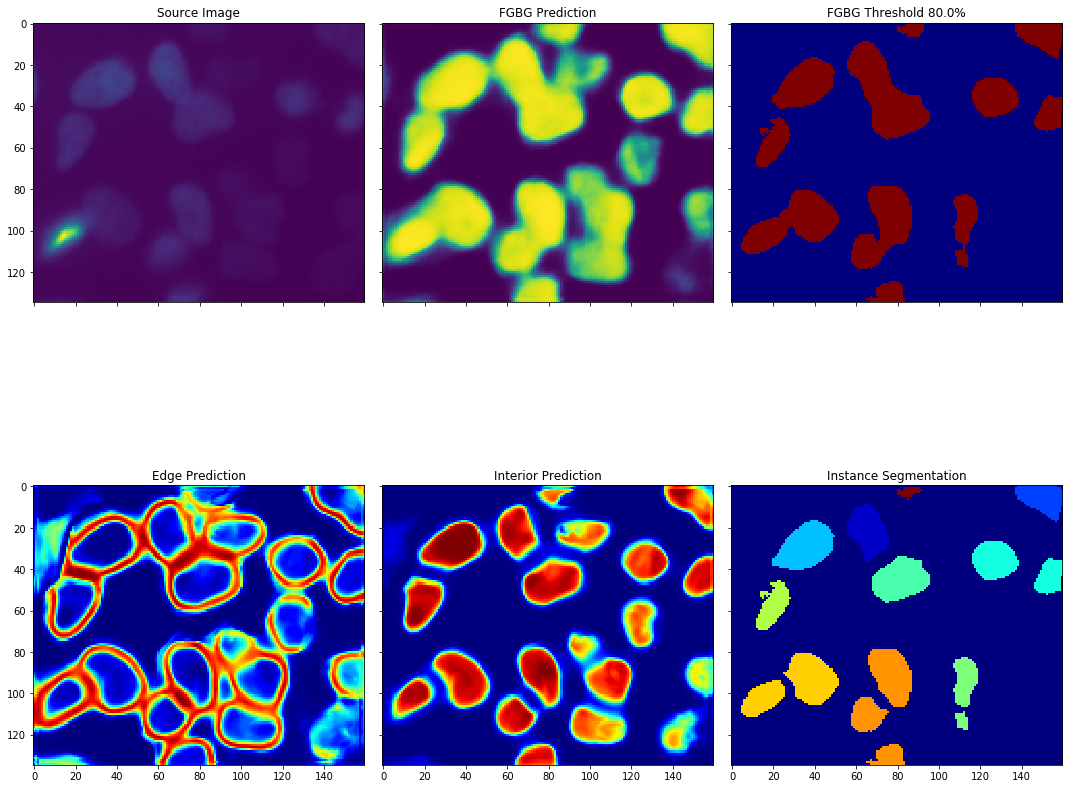

<Figure size 432x288 with 0 Axes>

In [27]:
X_test, y_test = test_dict['X'][:2], test_dict['y'][:2]


# Train model and get GPU info
conv_gru_model_name = 'conv_gru_featurenet_model_full'
fgbg_gru_model_name = 'fgbg_gru_featurenet_model_full'
fgbg_gru_weights_file = os.path.join(MODEL_DIR, '{}.h5'.format(fgbg_gru_model_name))
conv_gru_weights_file = os.path.join(MODEL_DIR, '{}.h5'.format(conv_gru_model_name))
test_images, test_images_fgbg = test_gru(X_test, fgbg_gru_weights_file, conv_gru_weights_file, 
                                         gru_kernel_size=3, gru=True)


labeled_images, fg_thresh = post_process(test_images, test_images_fgbg)
# labeled_images, fg_thresh = watershed_process(test_images, test_images_fgbg)

plot_results(X_test, test_images_fgbg, fg_thresh, test_images, labeled_images, conv_gru_model_name)

In [ ]:
X_test, y_test = test_dict['X'][:2], test_dict['y'][:2]
conv_model_name = 'conv_featurenet_model_watershed'
fgbg_model_name = 'fgbg_featurenet_model_full'

fgbg_weights_file = os.path.join(MODEL_DIR, '{}.h5'.format(fgbg_model_name))
conv_weights_file = os.path.join(MODEL_DIR, '{}.h5'.format(conv_model_name))
test_images, test_images_fgbg = test_gru(X_test, fgbg_weights_file, conv_weights_file, gru=False)


# labeled_images, fg_thresh = post_process(test_images, test_images_fgbg)
labeled_images, fg_thresh = watershed_process(test_images, test_images_fgbg)

plot_results(X_test, test_images_fgbg, fg_thresh, test_images, labeled_images, conv_model_name)